In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

**Data Exploration**

In [3]:
data=pd.read_csv("./seattle-weather.csv")
data.shape

(1461, 6)

In [4]:
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [5]:
data.tail()

,date,precipitation,temp_max,temp_min,wind,weather
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun
1460,2015-12-31,0.0,5.6,-2.1,3.5,sun


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


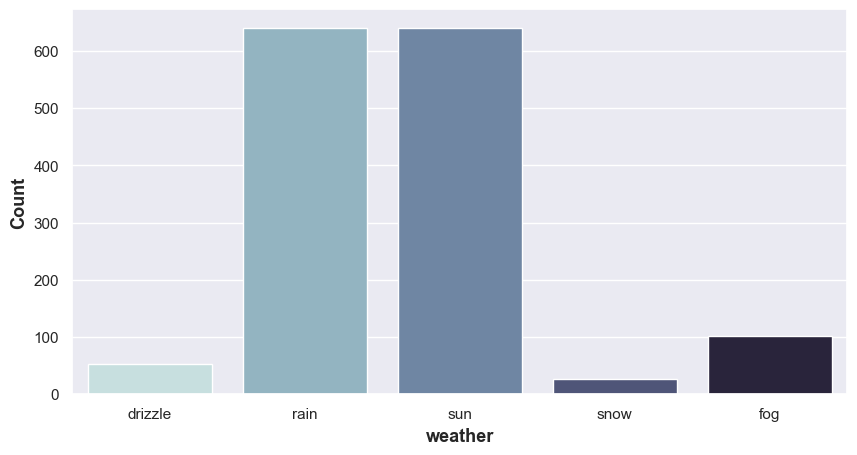

In [7]:
# Categorical variables
plt.figure(figsize=(10,5))
sns.set_theme()
sns.countplot(x = 'weather',data = data,palette="ch:start=.2,rot=-.3")
plt.xlabel("weather",fontweight='bold',size=13)
plt.ylabel("Count",fontweight='bold',size=13)
plt.savefig('Bar chart showing the distribution of categorical variables in the dataset')
plt.show()

In [8]:
countrain=len(data[data.weather=="rain"])
countsun=len(data[data.weather=="sun"])
countdrizzle=len(data[data.weather=="drizzle"])
countsnow=len(data[data.weather=="snow"])
countfog=len(data[data.weather=="fog"])
print("Percent of Rain:{:2f}%".format((countrain/(len(data.weather))*100)))
print("Percent of Sun:{:2f}%".format((countsun/(len(data.weather))*100)))
print("Percent of Drizzle:{:2f}%".format((countdrizzle/(len(data.weather))*100)))
print("Percent of Snow:{:2f}%".format((countsnow/(len(data.weather))*100)))
print("Percent of Fog:{:2f}%".format((countfog/(len(data.weather))*100)))

Percent of Rain:43.874059%
Percent of Sun:43.805613%
Percent of Drizzle:3.627652%
Percent of Snow:1.779603%
Percent of Fog:6.913073%


In [9]:
# Numerical variables
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


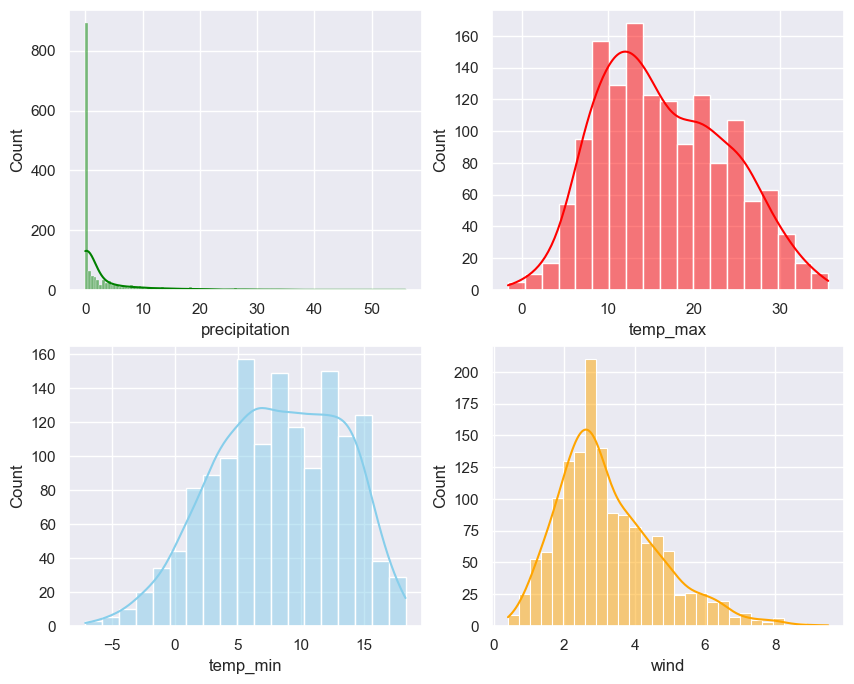

In [10]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=data,x="wind",kde=True,ax=axs[1,1],color='orange')
plt.savefig('Histogram showing the distribution of numerical variables in the dataset')

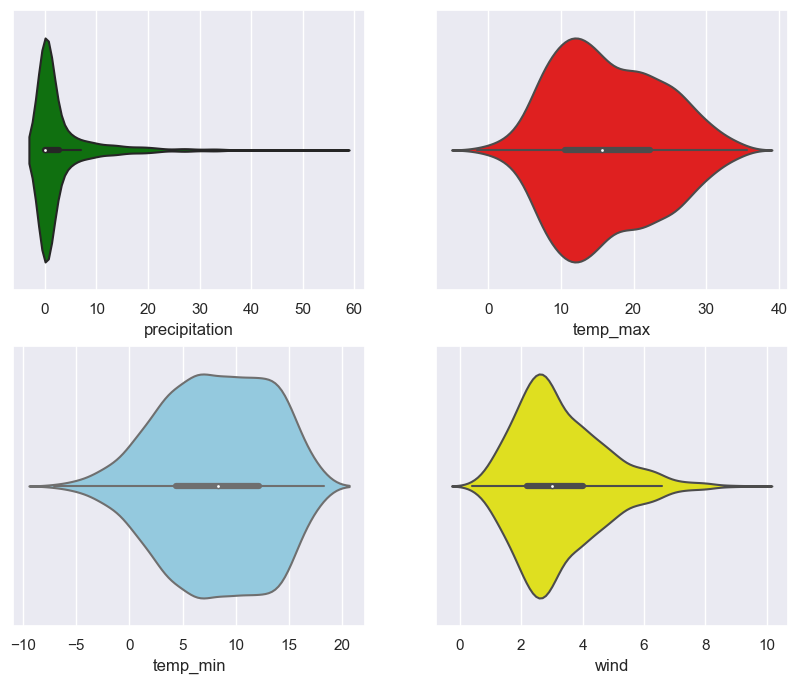

In [11]:
# Outlier analysis
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.violinplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.violinplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.violinplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.violinplot(data=data,x="wind",kde=True,ax=axs[1,1],color='yellow')
plt.savefig('Violin plot showing skewness in weather attribute distributions')

In [12]:
# Checking for null values
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

**Data Preprocessing**

In [13]:
# Remove unnecessary variables
df=data.drop(["date"],axis=1)

In [14]:
# Remove Outliers
Q1=df.quantile(0.25, numeric_only = True)
Q3=df.quantile(0.75, numeric_only = True)
IQR = Q3-Q1
df, IQR = df.align(IQR, axis = 1, copy = False)
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

In [15]:
# Skewed Distribution Treatment
df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

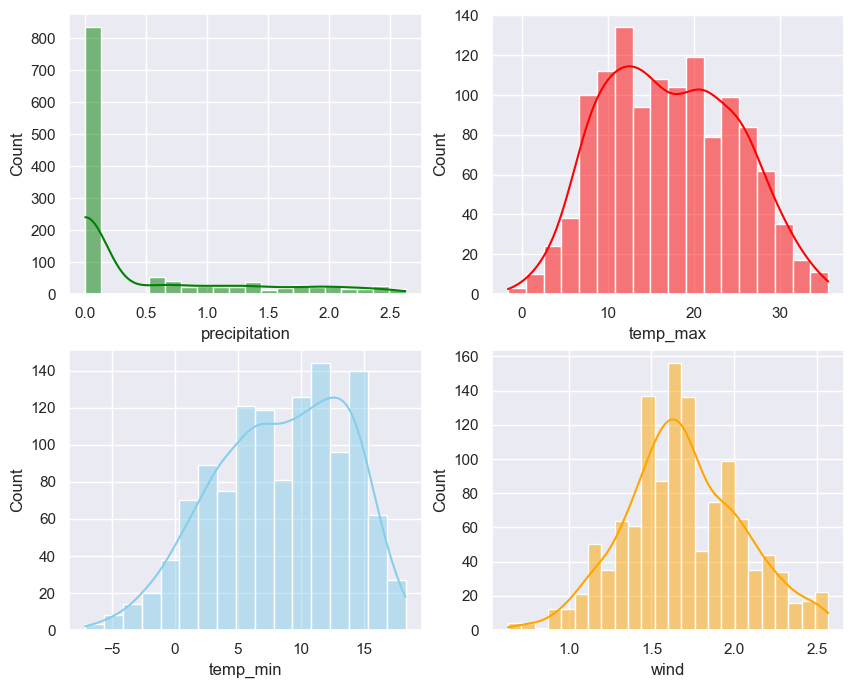

In [16]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')
plt.savefig('Histograms showing normalized distributions')

In [17]:
df.head()

,precipitation,temp_max,temp_min,weather,wind
0,0.000000,12.8,5.0,drizzle,2.167948
2,0.894427,11.7,7.2,rain,1.516575
4,1.140175,8.9,2.8,rain,2.469818
5,1.581139,4.4,2.2,rain,1.483240
6,0.000000,7.2,2.8,rain,1.516575


In [18]:
# Label encoding
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

In [19]:
df.head()

,precipitation,temp_max,temp_min,weather,wind
0,0.000000,12.8,5.0,0,2.167948
2,0.894427,11.7,7.2,2,1.516575
4,1.140175,8.9,2.8,2,2.469818
5,1.581139,4.4,2.2,2,1.483240
6,0.000000,7.2,2.8,2,1.516575


In [20]:
x = df.loc[:, df.columns != "weather"].values.astype(int)
y = df["weather"].values

In [21]:
df.weather.unique()

array([0, 2, 4, 3, 1])

In [22]:
# Train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

**Developing the Models**

In [23]:
# K-nearest neighbor (KNN) classifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_train_accuracy = knn.score(x_train, y_train)
knn_test_accuracy = knn.score(x_test, y_test)
print("Training Accuracy: {:.2f}%".format(knn_train_accuracy * 100))
print("Testing Accuracy: {:.2f}%".format(knn_test_accuracy * 100))

Training Accuracy: 75.38%
Testing Accuracy: 78.23%


In [24]:
# Support vector machine (SVM) classifier
svm = SVC()
svm.fit(x_train, y_train)
svm_train_accuracy = svm.score(x_train, y_train)
svm_test_accuracy = svm.score(x_test, y_test)
print("Training Accuracy: {:.2f}%".format(svm_train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(svm_test_accuracy * 100))

Training Accuracy: 71.24%
Test Accuracy: 77.42%


In [25]:
# Gradient boosting classifier (GBC)
gbc = GradientBoostingClassifier(subsample=0.5, n_estimators=450, max_depth=5, max_leaf_nodes=25)
gbc.fit(x_train, y_train)
gbc_train_accuracy = gbc.score(x_train, y_train)
gbc_test_accuracy = gbc.score(x_test, y_test)
print("Training Accuracy: {:.2f}%".format(gbc_train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(gbc_test_accuracy * 100))

Training Accuracy: 82.69%
Test Accuracy: 82.26%


In [26]:
# Extreme gradient boosting (XGB) classifier
import warnings
warnings.filterwarnings('ignore')
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_train_accuracy = xgb.score(x_train, y_train)
xgb_test_accuracy = xgb.score(x_test, y_test)
print("XGB Training Accuracy: {:.2f}%".format(xgb_train_accuracy * 100))
print("XGB Testing Accuracy: {:.2f}%".format(xgb_test_accuracy * 100))

XGB Training Accuracy: 81.15%
XGB Testing Accuracy: 82.26%


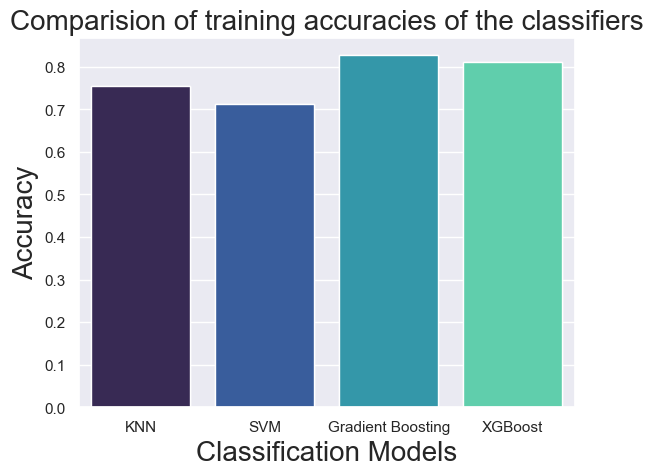

In [27]:
# Comparision of training accuracies of the classifiers
acc = [knn_train_accuracy,svm_train_accuracy,gbc_train_accuracy, xgb_train_accuracy]
classifiers = ['KNN', 'SVM', 'Gradient Boosting', 'XGBoost']
plt.bar(classifiers, acc)
ax = sns.barplot(x=classifiers, y=acc, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Comparision of training accuracies of the classifiers", fontsize = 20)
plt.savefig('Comparision of training accuracies of the classifiers')
plt.show()

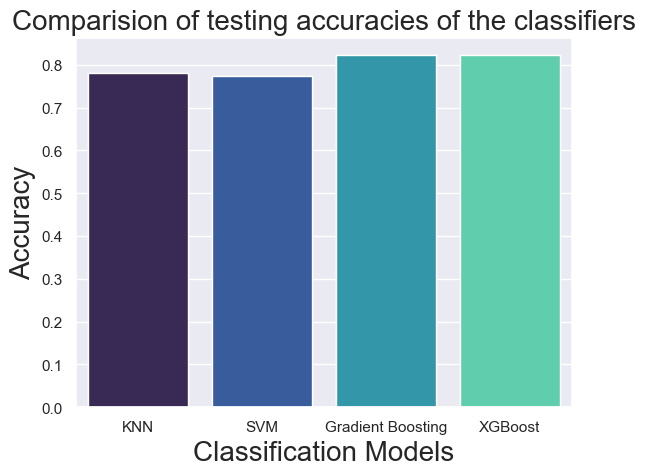

In [28]:
# Comparision of testing accuracies of the classifiers
acc = [knn_test_accuracy,svm_test_accuracy,gbc_test_accuracy, xgb_test_accuracy]
classifiers = ['KNN', 'SVM', 'Gradient Boosting', 'XGBoost']
plt.bar(classifiers, acc)
ax = sns.barplot(x=classifiers, y=acc, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Comparision of testing accuracies of the classifiers", fontsize = 20)
plt.savefig('Comparision of testing accuracies of the classifiers')
plt.show()

In [29]:
input=[[1.140175,8.9,2.8,2.469818]]
ot=gbc.predict(input)
print("The weather is:")
if(ot==0):
    print("Drizzle")
elif(ot==1):
    print("Fog")
elif(ot==2):
    print("Rain")
elif(ot==3):
    print("snow")
else:
    print("Sun")

The weather is:
Rain
